# Spooky NLP and Topic Modelling tutorial

- 데이터: [Spooky Author Identification](https://www.kaggle.com/competitions/spooky-author-identification)
- 필사 참조: https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial/notebook

### Description
손에 원고를 들고 촛붓이 켜진 방을 급히 가로질러 가면서, 나는 내가 해냈다고 생각했다. 그 무엇도 나를 더 이상 해칠 수 없을 것이다. 나는 모퉁이에 마지막 공포가 있다는 것을 전혀 알지 못했다.
<br/>

띵! 내 전화로 알림이 왔고, 그것은 Kaggle 진행자 중 가장 두려운 Will이었다.
<br/>

"ph'nglui mglw'nafh Cthulhu R'yehwgah'nagl ftagn!" 나는 제본되지 않은 으스스한 책 상자를 어설프게 떨어뜨리며 울었다. 페이지들이 방바닥에 흩어졌는데, 내가 어떻게 그들을 다시 작가들에 따라 조립할 수 있을까? Or 나는 영원히 길을 잃은 건가 ? 
<br/>

올해 할로윈 놀이터 대회에서, 너는 **Edgar Allan Poe, Mary Shelley, and HP Lovecraft가 쓴 공포 이야기에서 발췌한 저자를 예측**해야 한다. 

<br/>

### Data Description
이 대회는 으스스한 작가인 Edgar Allan Poe, Mary Shelley, and HP Lovecraft가 쓴 fiction들의 text를 포함한다. 이 데이터는 CoreNLP의 MaxEnt 문장 토크나이저를 사용해 더 큰 텍스트를 문장으로 chunking하여 작성했다. 따라서 너는 여기저기서 이상한 비문장을 찾을 수 있다. 네 목표는 test set에 있는 문장의 author을 정확히 식별하는 것이다.

### Introduction

이 노트북에서는 Spooky Author Dataset을 모델링하는 기본적인 시도를 진행할텐데, Topic Modelling은 텍스트 말뭉치의 기본 문서와 단어를 기반으로 추상적인 주제 or "주제"를 찾아내는 과정이다. 여기에 LDA라 불리는 디리클레 할당과 NMF로 아려진 비음수 행렬 인수분해를 이용해 두 가지 표준 주제 모델링 기법을 소개할 것이다. 또한 NLP의 기본인 Tokenization, Stemming, 원시 데이터 벡터화를 소개할 것이며, 학습 모델을 가지고 예측할 때 유용하길 바란다.

<br/>

### 진행 순서
1. **EDA and Wordclouds**
- 여러 작가들에 대한 단어 빈도수와 같은 simple 통계를 생성하고 word cloud를 그려 데이터 분석하기
2. **NLP with NLTK (Natural Language Toolkit)**
- 용어 빈도(TF), 역문서 빈도(TF-IDF)를 통해 토큰화, stop word 제거, stemming, 벡터화와 같은 기본 텍스트 정제 방법을 소개한다.
3. **Topic Modelling with LDA and NNMF**
- 2개의 topic modelling 기법인 LDA와 NMF를 수행함

In [3]:
import base64
import numpy as np
import pandas as pd

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
# from scipy.misc import imread
from imageio import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

> `ImportError: cannot import name 'imread' from 'scipy.misc'`

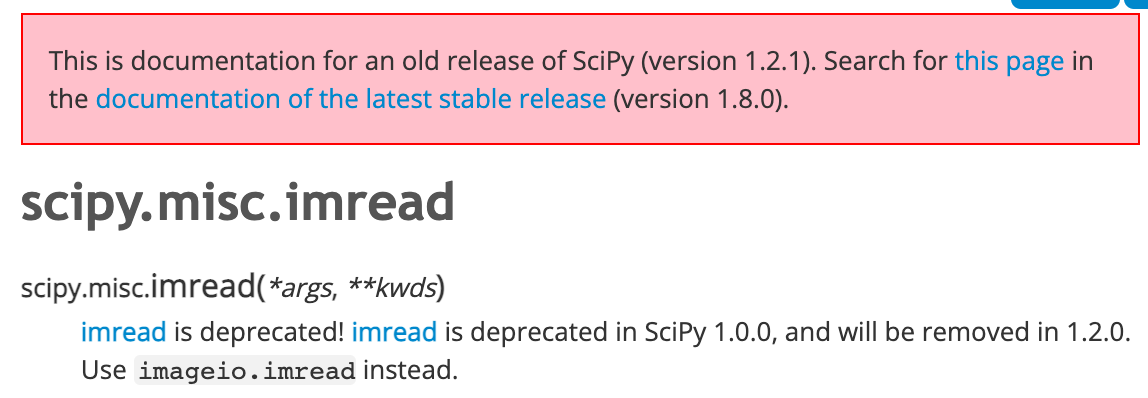

scipy의 공식 홈페이지를 보면 scipy의 imread는 1.2.0 버전 이후로는 사용되지 않아, **imageio의 imread를 사용하라고 권장**한다. Or **scipy의 1.2.0 이전 버전을 다운받기**

> - [참조 블로그](https://robot9710.tistory.com/5)

In [7]:
# Loading in the training data with Pandas

train = pd.read_csv('../data/Spooky/train.csv')

## 1. The Authors and their works EDA

첫 번째 단계로, 작가들이 누군지 첫 열들을 빠르게 확인해보자.

In [8]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


3명의 author
> 1. [EAP - Edgar Allen Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe)
> 2. [HPL - HP Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft)
> 3. [MWS - Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley)

In [9]:
print(train.shape)

(19579, 3)


### Summary statistics of the training set
각 작가의 분포와 같은 데이터의 기본 통계를 시각화하자. 이 때, Plot.ly 시각화 방법을 사용해 간단한 bar plot을 그릴 것이다.

In [11]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker = dict(colorscale = 'Jet',
                          color = train.author.value_counts().values
                         ),
            text = 'Text entries attributed to Author'
        )]

layout = go.Layout(
    title = 'Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [29]:
train.author.map(z)

0        Edgar Allen Poe
1           HP Lovecraft
2        Edgar Allen Poe
3           Mary Shelley
4           HP Lovecraft
              ...       
19574    Edgar Allen Poe
19575    Edgar Allen Poe
19576    Edgar Allen Poe
19577    Edgar Allen Poe
19578       HP Lovecraft
Name: author, Length: 19579, dtype: object

In [17]:
train.author.map(z).unique()

array(['Edgar Allen Poe', 'HP Lovecraft', 'Mary Shelley'], dtype=object)

In [30]:
train.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [18]:
train.author.value_counts().values

array([7900, 6044, 5635])

<AxesSubplot:title={'center':'Target variable distribution'}>

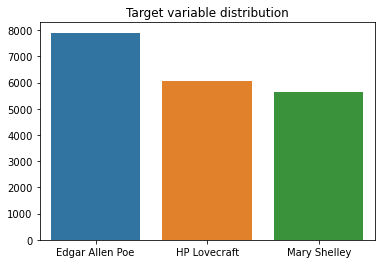

In [28]:
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

x = train.author.map(z).unique()
y = train.author.value_counts().values
plt.title('Target variable distribution')

sns.barplot(x, y)